In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet
from manifold_mixup import *
from dynamic_mixup import *
from rlamb import *

In [3]:
GPU = 3
np.random.seed(1773)
MODEL =  EfficientNet.from_pretrained('efficientnet-b7', num_classes=3)
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
BS = 8
SIZE = 512
EXP_NAME = "{}-{}-{}".format(BS, SIZE, exp_time)
TEST_PATH = "/home/ubuntu/crop/data_v1/test"
print(EXP_NAME)

Loaded pretrained weights for efficientnet-b7
8-512-2020-03-22_06:50:00


In [4]:
CSV_PATH = "/home/ubuntu/crop/notebooks/fastai2/Prod/cv{}.csv".format(1)
df = pd.read_csv(CSV_PATH)

In [5]:
df["label"].value_counts()

stem_rust        376
leaf_rust        358
healthy_wheat    142
Name: label, dtype: int64

In [6]:
opt_func = partial(Adam)

In [7]:
item_tfms = [Resize(SIZE)]
batch_tfms = [Rotate(), Flip(),  Normalize.from_stats(*imagenet_stats)]

In [8]:
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/crop/data_v3/train", 
                                item_tfms=item_tfms,batch_tfms=batch_tfms,
                                bs=BS, num_workers=16, device=GPU)

Could not do one pass in your dataloader, there is something wrong in it


In [9]:
cbs = [DynamicOutputMixup(scheduler=SchedLin, alpha_max=0., alpha_min=1.)] 
learn = Learner(dls, MODEL, metrics=[error_rate, accuracy], cbs=cbs, opt_func=opt_func).to_fp16()

Scheduler detected, growing alpha from 1.0 to 0.0


In [10]:
learn.freeze()
learn.fit_one_cycle(100, slice(2e-3), cbs=[EarlyStoppingCallback(patience=3), SaveModelCallback(fname=EXP_NAME)])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.943213,0.688605,0.234286,0.765714,01:01
1,0.702634,0.393281,0.108571,0.891429,00:55
2,0.603170,0.391352,0.102857,0.897143,00:55
3,0.532381,0.455299,0.165714,0.834286,00:55
4,0.527885,0.558800,0.194286,0.805714,00:55
5,0.560235,0.429435,0.120000,0.880000,00:54


No improvement since epoch 2: early stopping


In [11]:
learn.unfreeze()
cbs_1 = EarlyStoppingCallback(patience=3, min_delta=1e-5, monitor="error_rate")
cbs_2 = SaveModelCallback(fname=EXP_NAME)
learn.fit_one_cycle(100, slice(1e-7, 1e-4), cbs=[cbs_1, cbs_2])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.523624,0.379615,0.120000,0.880000,00:55
1,0.514577,0.375407,0.114286,0.885714,00:54
2,0.500312,0.373578,0.120000,0.880000,00:55
3,0.496940,0.374670,0.114286,0.885714,00:55
4,0.495855,0.374735,0.125714,0.874286,00:54


No improvement since epoch 1: early stopping


Output mixup: the loss function is now properly wrapped.


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=1.5848931056439142e-08)

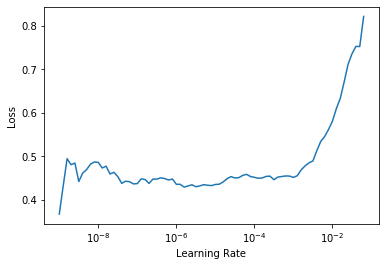

In [12]:
learn.freeze()
learn.lr_find(start_lr=1e-09, suggestions=True)

In [13]:
cbs_1 = EarlyStoppingCallback(patience=3, min_delta=1e-7, monitor="error_rate")
cbs_2 = SaveModelCallback(fname=EXP_NAME)
learn.fit_one_cycle(100, slice(1e-9), cbs=[cbs_1, cbs_2])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.510650,0.373877,0.120000,0.880000,00:55
1,0.520486,0.374400,0.131429,0.868571,00:55
2,0.502702,0.375407,0.131429,0.868571,00:54
3,0.483277,0.374547,0.131429,0.868571,00:55


No improvement since epoch 0: early stopping


Output mixup: the loss function is now properly wrapped.


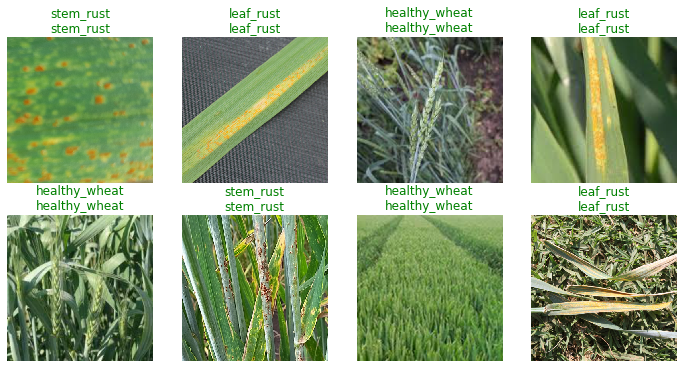

In [14]:
learn.show_results()

Output mixup: the loss function is now properly wrapped.


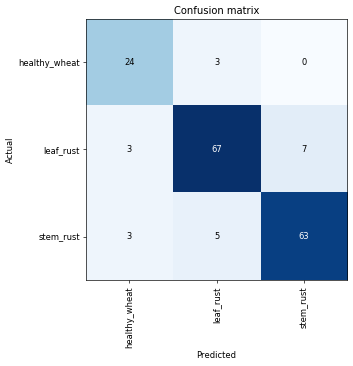

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)

In [16]:
interp.most_confused()

[('leaf_rust', 'stem_rust', 7),
 ('stem_rust', 'leaf_rust', 5),
 ('healthy_wheat', 'leaf_rust', 3),
 ('leaf_rust', 'healthy_wheat', 3),
 ('stem_rust', 'healthy_wheat', 3)]

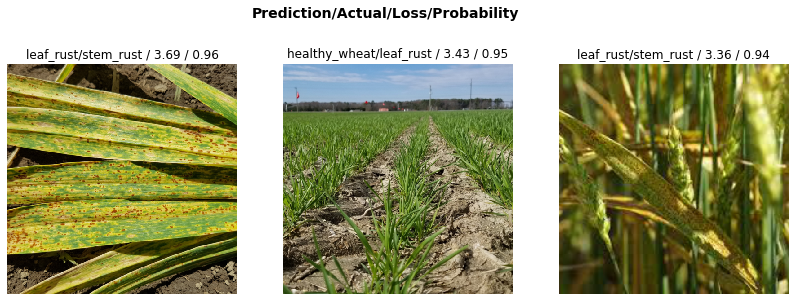

In [17]:
interp.plot_top_losses(3, figsize=(14,5))

In [18]:
ac_1 = learn.validate(); ac_1

Output mixup: the loss function is now properly wrapped.


(#3) [0.3738773763179779,0.11999999731779099,0.8799999952316284]

In [19]:
learn = learn.to_fp32()

In [20]:
learn.save("/home/ubuntu/crop/models/"+EXP_NAME)

In [21]:
path = "/home/ubuntu/crop/data_v1/test"
imgs = get_image_files(path)

In [22]:
test_dl = dls.test_dl(imgs)

In [23]:
tta_preds, tta_targ = learn.tta(dl=test_dl, item_tfms=item_tfms)

In [24]:
preds, _ = learn.get_preds(dl=test_dl) 

tensor([[0.9298, 0.0305, 0.0397],
        [0.0085, 0.0594, 0.9321],
        [0.5563, 0.0332, 0.4105],
        [0.0263, 0.0833, 0.8904],
        [0.0084, 0.1459, 0.8456],
        [0.0109, 0.4916, 0.4975],
        [0.0725, 0.0189, 0.9086],
        [0.0633, 0.9120, 0.0247],
        [0.9107, 0.0715, 0.0178],
        [0.3948, 0.0622, 0.5429],
        [0.0192, 0.9696, 0.0112],
        [0.9419, 0.0485, 0.0097],
        [0.0303, 0.0873, 0.8824],
        [0.0063, 0.9570, 0.0367],
        [0.0078, 0.0159, 0.9764],
        [0.0406, 0.0212, 0.9382],
        [0.0122, 0.9680, 0.0198],
        [0.0126, 0.9435, 0.0439],
        [0.0521, 0.0165, 0.9314],
        [0.0099, 0.9171, 0.0730],
        [0.0420, 0.9311, 0.0269],
        [0.0153, 0.9456, 0.0392],
        [0.0125, 0.9525, 0.0350],
        [0.1434, 0.6121, 0.2445],
        [0.0064, 0.0202, 0.9733],
        [0.0024, 0.0213, 0.9763],
        [0.0231, 0.9625, 0.0144],
        [0.0310, 0.7673, 0.2016],
        [0.0958, 0.2814, 0.6228],
        [0.014